In [36]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_ReInit"): print("\nThe data folder \"_data_temp/convergence_analysis2/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis2/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis2/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_temp/convergence_analysis2/


### Define Potential and default parameters

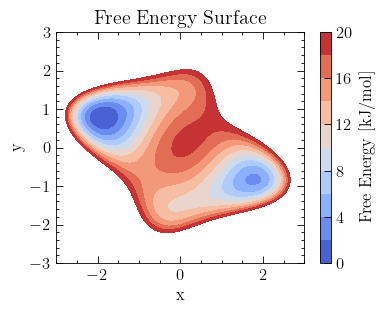

In [26]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
dinve_pot_dy, dinve_pot_dx = np.gradient(inve_pot, grid, grid)
inve_pot = inve_pot - np.min(inve_pot)
inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
FES_cutoff = 20

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, inve_pot, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Free Energy Surface"); plt.show()

# Stimulation path
path_invernizzi = path_data + "Invernizzi_Potential/"

In [61]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], "dZ_dX":dinve_pot_dx, "dZ_dY":dinve_pot_dy,
                    "plX":plX, "plY":plY, "simulation_steps":1_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.186, 0.186], "metad_height":1, "biasfactor":10,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":200,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, 
                    "simulation_folder_path": path_invernizzi, "print_info": False}

### Run Long simulation for reference

Time taken for Long simulation: 30.2929 sec
Final Error: Aofe = 1.0732, AAD = 0.5571
MIN1 = 29.8575, MIN2 = 30.0083


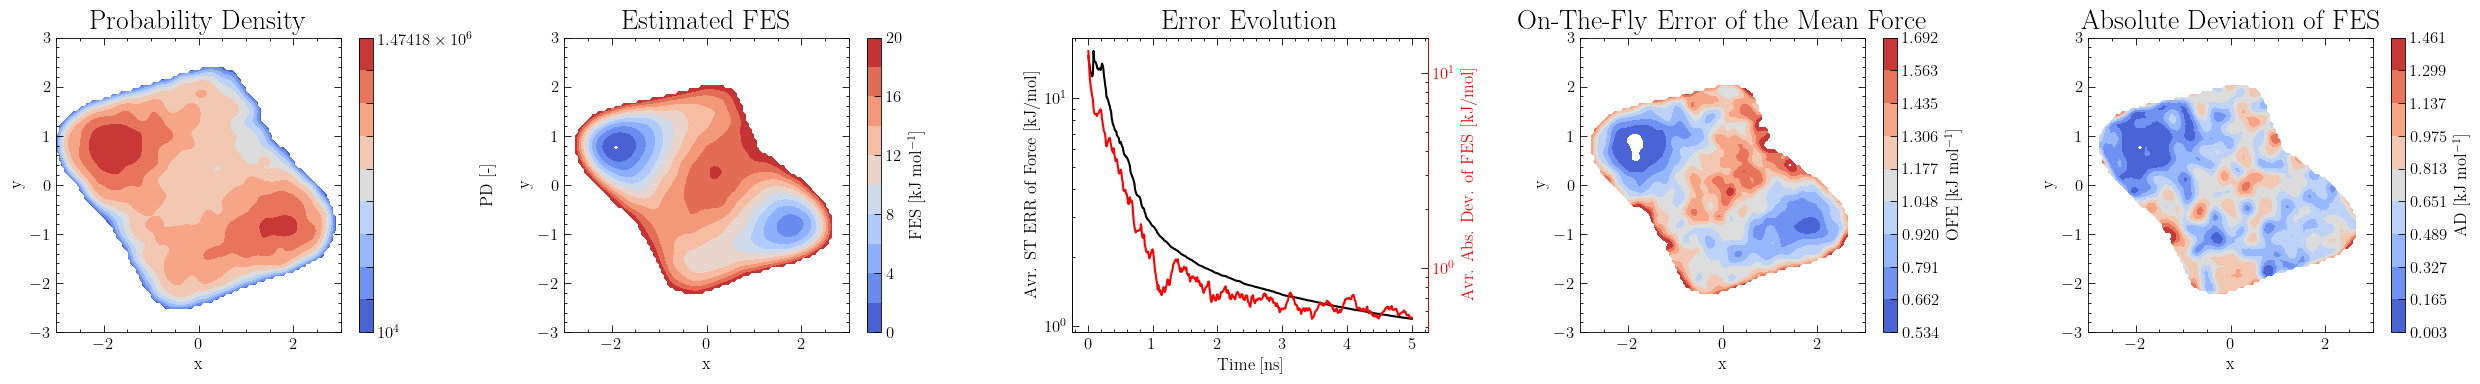

In [62]:
new_params = {**default_params}
new_params.update({"ID":"_long"})
new_params.update({"simulation_steps":1_000_000, "len_error_list":500})#, "n_pos":10_000})

start_long = time.time()
MFI_long = MFI_class2D.MFI2D(**new_params)
MFI_long.run_simulation()
MFI_long.analyse_data()
finish_long = time.time()

print(f"Time taken for Long simulation: {finish_long - start_long:.4f} sec")
print(F"Final Error: Aofe = {MFI_long.Aofe:.4f}, AAD = {MFI_long.AAD:.4f}")
print(f"MIN1 = {np.min(MFI_long.FES + MFI_long.Bias):.4f}, MIN2 = {np.min(inve_pot + MFI_long.Bias):.4f}")

MFI_long.plot_res()
t_long, v_long, aofe_long, aad_long = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,1], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]


### Exploration simulation

Time taken for Expl. simulation: 0.9868 sec
Final Error: Aofe = 4.7798, AAD = 1.4246
MIN1 = 23.1522, MIN2 = 20.4334


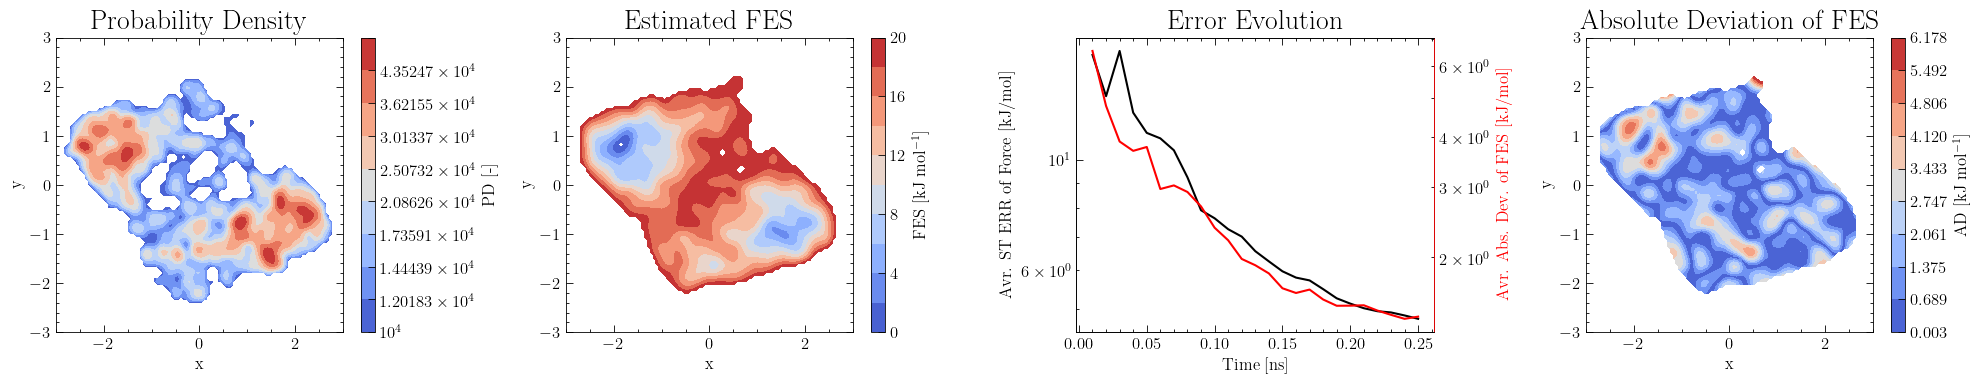

ready to show


In [63]:
new_params = {**default_params}
new_params.update({"ID":"_expl", "metad_height":5, "biasfactor":100})
new_params.update({"simulation_steps":50_000, "len_error_list":25})#, "n_pos":10_000})

start_expl = time.time()
MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.run_simulation()
MFI_expl.analyse_data()
finish_expl = time.time()

print(f"Time taken for Expl. simulation: {finish_expl - start_expl:.4f} sec")
print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(inve_pot + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(inve_pot + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]


### 2nd Stage - 1x MetaD simulation

Time taken for MetaD. simulation: 17.8913 sec
Final Error: Aofe = 1.0746, AAD = 0.4262


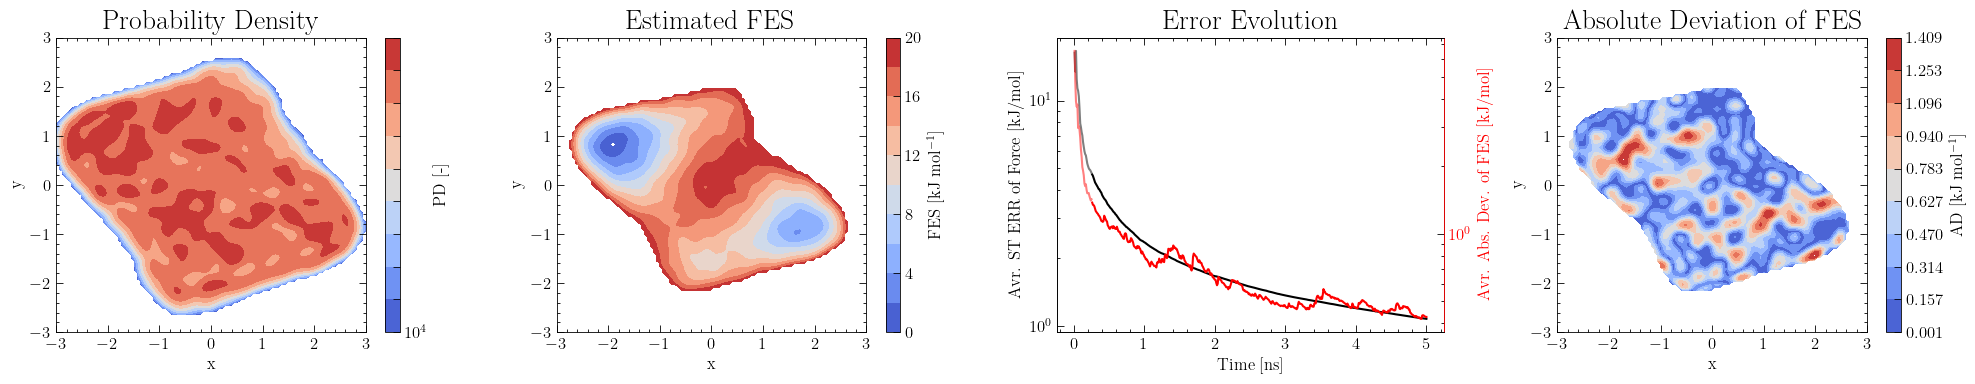

In [68]:
new_params = {**default_params}
new_params.update({"ID":"_metad"})
new_params.update({"simulation_steps":950_000, "len_error_list":475})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad = time.time()
MFI_metad = MFI_class2D.MFI2D(**new_params)
MFI_metad.make_external_bias(FES=MFI_expl.FES)
MFI_metad.run_simulation()
MFI_metad.analyse_data()
finish_metad = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad - start_metad:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad.Aofe:.4f}, AAD = {MFI_metad.AAD:.4f}")

MFI_metad.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.Avr_Error_info.index("AAD")]
t1x1, aofe1x1, aad1x1 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

### 2nd Stage - 2x MetaD simulations

In [85]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2);

All simulations finished
Time taken for MetaD. simulation: 30.7876 sec
Final Error: Aofe = 0.8478, AAD = 0.3864


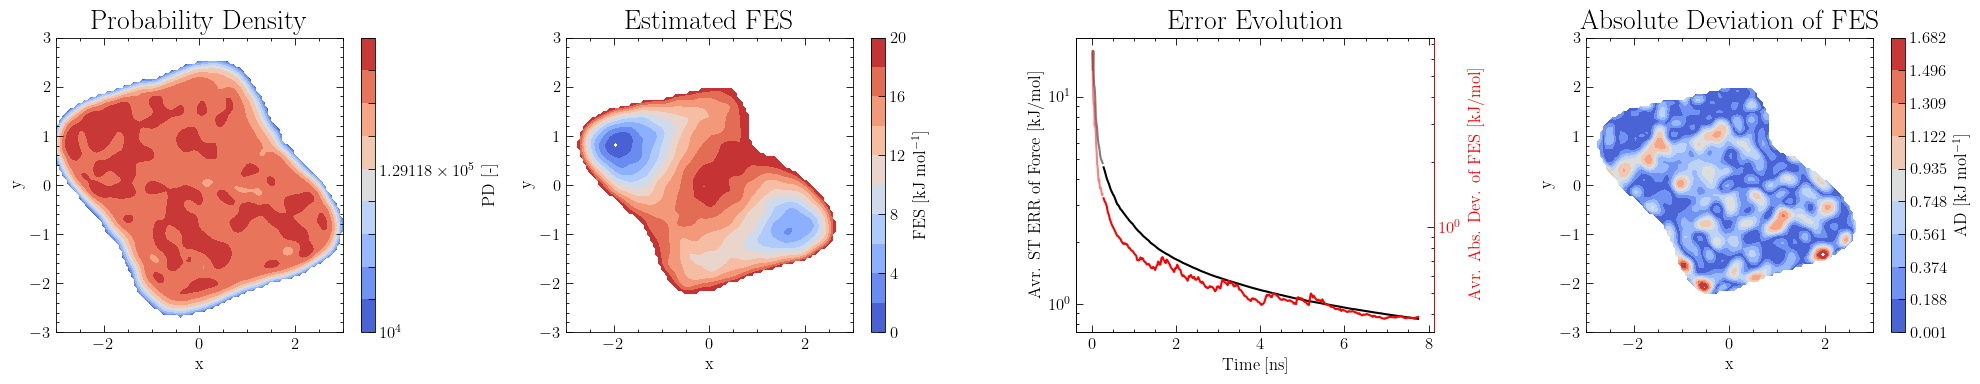

In [86]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x2"})
new_params.update({"simulation_steps":750_000, "len_error_list":300})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x2 = time.time()
MFI_metad_x2 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x2.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x2 = MFI_metad_x2.MFI_parallel(parent=MFI_metad_x2, workers=2)
mfi_parallel_x2.run_parallel_sim()
mfi_parallel_x2.analyse_parallel()
mfi_parallel_x2.patch_simulations()
finish_metad_x2 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x2 - start_metad_x2:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x2.Aofe:.4f}, AAD = {MFI_metad_x2.AAD:.4f}")

MFI_metad_x2.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x2, aofe_x2, aad_x2 = MFI_metad_x2.Avr_Error_list[:,0], MFI_metad_x2.Avr_Error_list[:,2], MFI_metad_x2.Avr_Error_list[:, MFI_metad_x2.aad_index]
t1x2, aofe1x2, aad1x2 = np.concatenate((t_expl, t_x2)), np.concatenate((aofe_expl, aofe_x2)), np.concatenate((aad_expl, aad_x2))


### 2nd Stage - 3x MetaD simulations

All simulations finished
Time taken for MetaD. simulation: 18.4508 sec
Final Error: Aofe = 0.7675, AAD = 0.3731


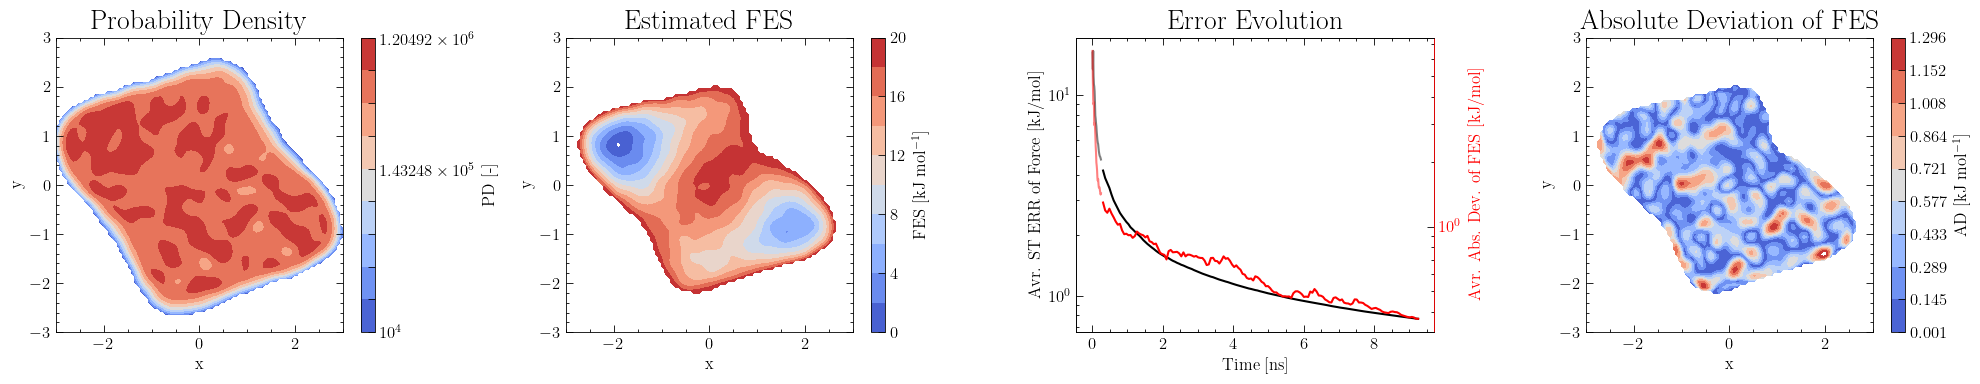

In [90]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x3"})
new_params.update({"simulation_steps":600_000, "len_error_list":150})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x3 = time.time()
MFI_metad_x3 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x3.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x3 = MFI_metad_x3.MFI_parallel(parent=MFI_metad_x3, workers=3)
mfi_parallel_x3.run_parallel_sim()
mfi_parallel_x3.analyse_parallel()
mfi_parallel_x3.patch_simulations()
finish_metad_x3 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x3 - start_metad_x3:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x3.Aofe:.4f}, AAD = {MFI_metad_x3.AAD:.4f}")

MFI_metad_x3.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x3, aofe_x3, aad_x3 = MFI_metad_x3.Avr_Error_list[:,0], MFI_metad_x3.Avr_Error_list[:,2], MFI_metad_x3.Avr_Error_list[:, MFI_metad_x3.aad_index]
t1x3, aofe1x3, aad1x3 = np.concatenate((t_expl, t_x3)), np.concatenate((aofe_expl, aofe_x3)), np.concatenate((aad_expl, aad_x3))


### 2nd Stage - 4x MetaD simulations

All simulations finished
Time taken for MetaD. simulation: 18.4508 sec
Final Error: Aofe = 0.7239, AAD = 0.5129


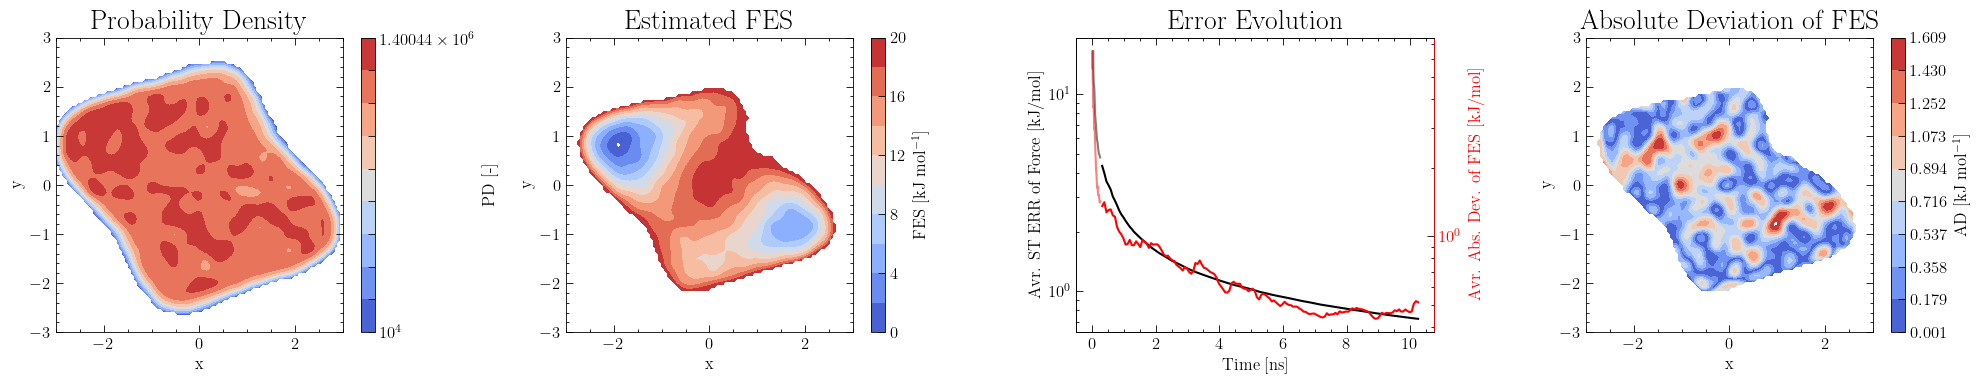

In [91]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x4"})
new_params.update({"simulation_steps":500_000, "len_error_list":150})#, "n_pos":10_000})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":base_forces_e_list})

start_metad_x4 = time.time()
MFI_metad_x4 = MFI_class2D.MFI2D(**new_params)
MFI_metad_x4.make_external_bias(FES=MFI_expl.FES)
mfi_parallel_x4 = MFI_metad_x4.MFI_parallel(parent=MFI_metad_x4, workers=4)
mfi_parallel_x4.run_parallel_sim()
mfi_parallel_x4.analyse_parallel()
mfi_parallel_x4.patch_simulations()
finish_metad_x4 = time.time()

print(f"Time taken for MetaD. simulation: {finish_metad_x3 - start_metad_x3:.4f} sec")
print(F"Final Error: Aofe = {MFI_metad_x4.Aofe:.4f}, AAD = {MFI_metad_x4.AAD:.4f}")

MFI_metad_x4.plot_res(["AD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
# MFI_2_1.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
t_x4, aofe_x4, aad_x4 = MFI_metad_x4.Avr_Error_list[:,0], MFI_metad_x4.Avr_Error_list[:,2], MFI_metad_x4.Avr_Error_list[:, MFI_metad_x4.aad_index]
t1x4, aofe1x4, aad1x4 = np.concatenate((t_expl, t_x4)), np.concatenate((aofe_expl, aofe_x4)), np.concatenate((aad_expl, aad_x4))


### Compare Convergence of Simulations

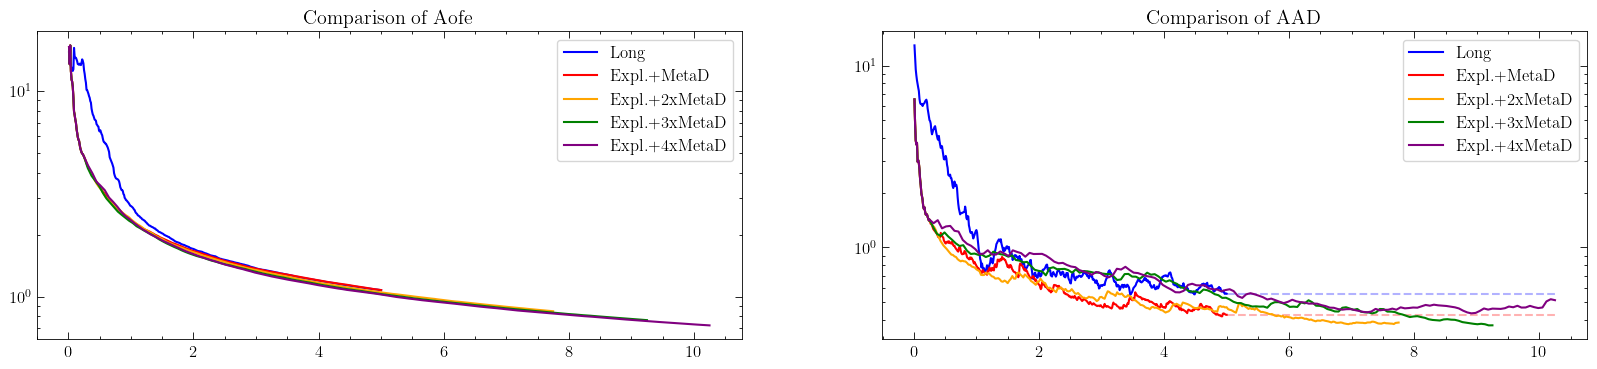

In [94]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.plot(t_long, aofe_long, label="Long", color="blue")
plt.plot(t1x1, aofe1x1, label="Expl.+MetaD", color="red")
plt.plot(t1x2, aofe1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aofe1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aofe1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(t_long, aad_long, label="Long", color="blue"); plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t1x1, aad1x1, label="Expl.+MetaD", color="red"); plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(t1x2, aad1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aad1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aad1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
